In [1]:

import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
import dagshub
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV


In [2]:
dagshub.init(repo_owner='manikantmnnit', repo_name='swiggy-delivery-time-prediction', mlflow=True)

Accessing as manikantmnnit

Initialized MLflow to track repo "manikantmnnit/swiggy-delivery-time-prediction"

Repository manikantmnnit/swiggy-delivery-time-prediction initialized!

In [3]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data


In [4]:
df = pd.read_csv(r'D:\Campus X\projects\swiggy-delivery-time-prediction\data\raw\swiggy.csv')

# clean data
data_clean_utils.perform_data_cleaning(df)


In [5]:
# laod cleaned data
cleaned_data=pd.read_csv('swiggy_cleaned.csv')

# delete unwanted columns
columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day"]
cleaned_data.drop(columns=columns_to_drop,inplace=True)
cleaned_data.sample(10)



,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
33828,28.0,5.0,cloudy,low,0,meal,motorcycle,0.0,no,metropolitian,19,RANCHI,3,monday,0,15.0,morning,1.509464,short
21870,20.0,4.7,windy,high,1,meal,motorcycle,1.0,no,metropolitian,18,HYD,4,sunday,1,15.0,afternoon,6.146967,medium
17151,25.0,4.9,sunny,low,0,meal,motorcycle,1.0,no,metropolitian,23,BANG,4,monday,0,5.0,night,12.420693,long
39995,26.0,4.3,stormy,high,0,meal,motorcycle,1.0,no,metropolitian,37,COIMB,3,wednesday,0,15.0,morning,3.116142,short
30158,20.0,4.8,sunny,jam,2,buffet,electric_scooter,1.0,no,metropolitian,19,MYS,3,wednesday,0,10.0,evening,7.772220,medium
13839,28.0,4.8,stormy,high,0,drinks,motorcycle,1.0,no,metropolitian,16,CHEN,4,sunday,1,5.0,morning,3.104782,short
16315,24.0,4.9,sunny,low,1,meal,motorcycle,1.0,no,metropolitian,20,BANG,3,tuesday,0,5.0,night,4.657655,short
3161,38.0,4.9,fog,jam,2,buffet,scooter,2.0,no,metropolitian,44,RANCHI,3,tuesday,0,15.0,evening,NaN,NaN
4259,20.0,5.0,sunny,low,1,drinks,motorcycle,0.0,no,metropolitian,23,LUDH,2,friday,0,5.0,morning,1.465203,short
22130,38.0,4.6,sunny,jam,0,snack,motorcycle,2.0,no,metropolitian,40,MUM,3,tuesday,0,5.0,night,10.704161,long


In [6]:
print(cleaned_data.info())
print('*'*50)
print(cleaned_data.isnull().sum())
print('*'*50)
print(cleaned_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45502 entries, 0 to 45501
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  43648 non-null  float64
 1   ratings              43594 non-null  float64
 2   weather              44977 non-null  object 
 3   traffic              44992 non-null  object 
 4   vehicle_condition    45502 non-null  int64  
 5   type_of_order        45502 non-null  object 
 6   type_of_vehicle      45502 non-null  object 
 7   multiple_deliveries  44509 non-null  float64
 8   festival             45274 non-null  object 
 9   city_type            44304 non-null  object 
 10  time_taken           45502 non-null  int64  
 11  city_name            45502 non-null  object 
 12  order_month          45502 non-null  int64  
 13  order_day_of_week    45502 non-null  object 
 14  is_weekend           45502 non-null  int64  
 15  pickup_time_minutes  43862 non-null 

<Axes: >

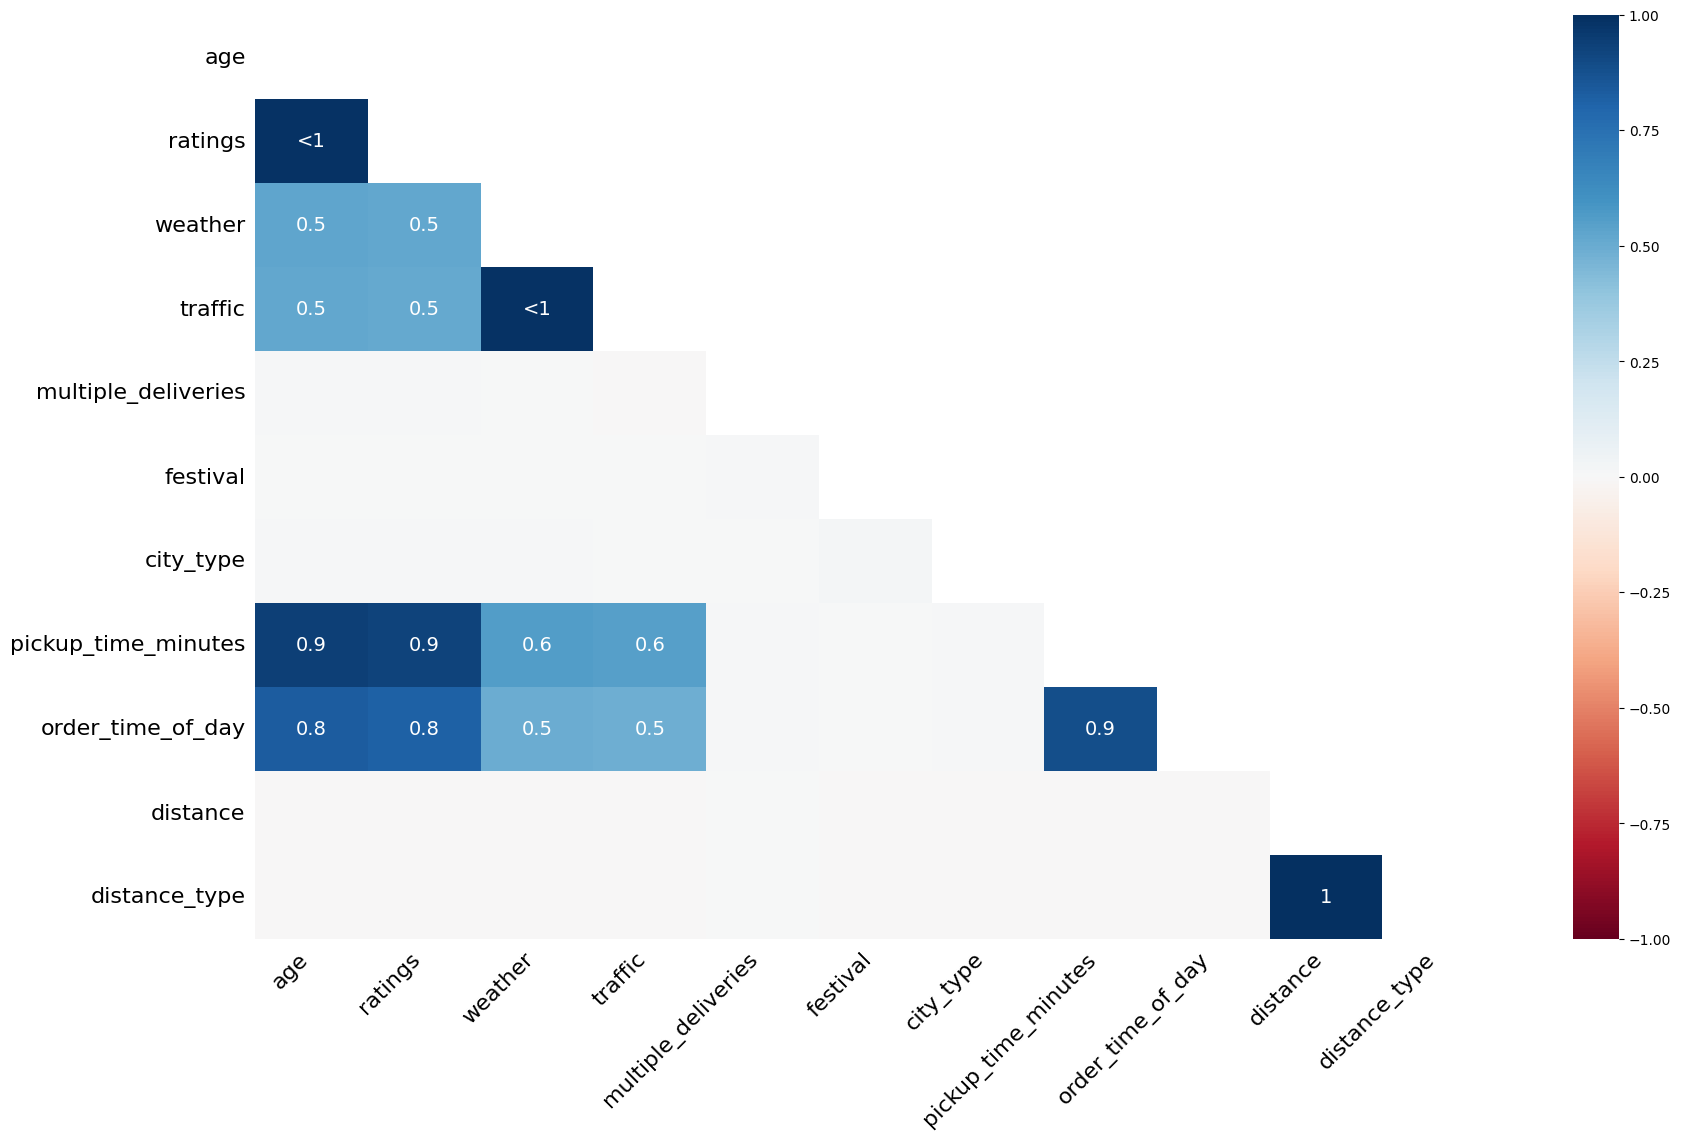

In [7]:
msno.heatmap(cleaned_data)

In [8]:
(
    cleaned_data.isna()
    .any()
    .loc[lambda x:x]
    .index
     
)

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing Values

In [9]:
import mlflow
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/manikantmnnit/swiggy-delivery-time-prediction.mlflow")

In [10]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Keep Vs Drop Missing Values")

<Experiment: artifact_location='mlflow-artifacts:/553ad788ed244859b0c0244b6799c49c', creation_time=1736471530769, experiment_id='0', last_update_time=1736471530769, lifecycle_stage='active', name='Exp 1 - Keep Vs Drop Missing Values', tags={}>

In [11]:
temp_df =  cleaned_data.copy().dropna()

In [12]:
x=temp_df.drop(columns='time_taken')
y=temp_df['time_taken']
print(r'feature and target shape are {} and {}'.format(x.shape,y.shape))

# split the train and test data set
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

print(r'size of x train and y train are {} and {}'.format(x_train.shape,y_train.shape))

# check null values
print(f'total null values in train data set is {x_train.isnull().sum().sum()}')

feature and target shape are (37695, 18) and (37695,)
size of x train and y train are (30156, 18) and (30156,)
total null values in train data set is 0


# basic dataprocessing

In [13]:
num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type","city_type"]
# Generate order of ordinal
traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]
city_type_order=['urban','semi-urban', 'metropolitian']

In [14]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),  # Scale numeric columns to a range between 0 and 1
        ("nominal_encode", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),  # Encode nominal categorical columns using One-Hot Encoding, dropping the first category to avoid redundancy
        ("ordinal_encode", OrdinalEncoder(categories=[traffic_order, distance_type_order, city_type_order]), ordinal_cat_cols)  # Encode ordinal categorical columns based on a predefined order
    ],
    remainder="passthrough",  # Keeps remaining columns as-is in the final transformed data
    n_jobs=-1,                # Uses all available CPU cores for parallel processing
    force_int_remainder_cols=False,  # Ensures remainder columns are not forcibly converted to integers
    verbose_feature_names_out=False  # Simplifies transformed feature names, disabling verbose output
)

# Set output to Pandas
preprocessor.set_output(transform="pandas")


ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long'],
                                                            ['urban',
                                                             'semi-urban',
                                                             'metropolitian']]),
                                 ['traffic', 'distance_type', 'city_type'])],
                  verbose_feature_names_out=False)

In [15]:
# transform the data
x_train_trans=preprocessor.fit_transform(x_train)
x_test_trans=preprocessor.transform(x_test)

print(f'shape of x train is {x_train_trans.shape}')

# transform target column
print(f'shape of y_train is {y_train.shape}')

pt = PowerTransformer() # # Applies a power transformation to make data more Gaussian-like and stabilize variance

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
print(f'shape of y_train_pt is {y_train_pt.shape}')
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

shape of x train is (30156, 55)
shape of y_train is (30156,)
shape of y_train_pt is (30156, 1)


# Train Initial Baseline Model


In [16]:
rf = RandomForestRegressor()

rf.fit(x_train_trans,y_train_pt)
# get the predictions
y_pred_train = rf.predict(x_train_trans)
y_pred_test = rf.predict(x_test_trans)

# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")


c:\Users\manik\anaconda3\envs\swiggy_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


The train error is 1.16 minutes
The test error is 3.09 minutes
The train r2 score is 0.98
The test r2 score is 0.83


In [17]:

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,x_train_trans,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)
# mean score

scores.mean()


0.8087025853440208

<Axes: >

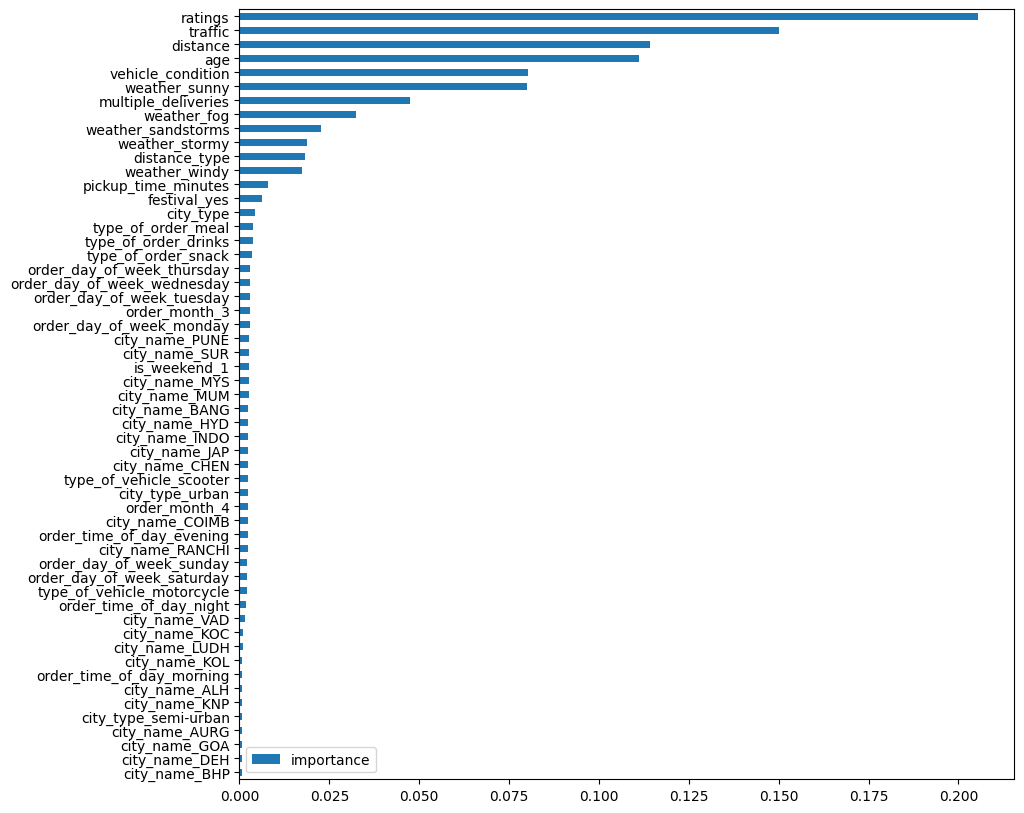

In [18]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=x_train_trans.columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [19]:
# log experiment

with mlflow.start_run(run_name="Drop Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Drop Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Drop Missing Values at: https://dagshub.com/manikantmnnit/swiggy-delivery-time-prediction.mlflow/#/experiments/0/runs/f5d97ab59d7b41d79c0655a941c3aefb
🧪 View experiment at: https://dagshub.com/manikantmnnit/swiggy-delivery-time-prediction.mlflow/#/experiments/0


In [20]:
# feature selection using rfecv

rfecv = RFECV(
    estimator=rf,       # The machine learning model (e.g., RandomForestRegressor in this case)
    step=10,            # Number of features to remove at each iteration (removes 10 features per step)
    cv=5,               # Number of cross-validation folds (5-fold cross-validation)
    scoring='r2',       # Scoring metric used to evaluate the model (R² in this case)
    n_jobs=-1,          # Use all available CPU cores for parallel processing
    verbose=2           # Display detailed progress information during the execution
)

In [21]:
# select features

rfecv.fit(x_train_trans,y_train_pt.values.ravel())

Fitting estimator with 55 features.
Fitting estimator with 45 features.
Fitting estimator with 35 features.


RFECV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1, scoring='r2', step=10,
      verbose=2)

In [22]:
# list of selected features

rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_scooter', 'festival_yes',
       'order_month_3', 'order_day_of_week_monday',
       'order_day_of_week_thursday', 'order_day_of_week_tuesday',
       'order_day_of_week_wednesday', 'is_weekend_1', 'traffic',
       'distance_type', 'city_type', 'vehicle_condition',
       'multiple_deliveries'], dtype=object)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(x_train_trans),y_train_pt.values.ravel())

RandomForestRegressor()

In [24]:
# get the predictions
y_pred_train = rf.predict(rfecv.transform(x_train_trans))
y_pred_test = rf.predict(rfecv.transform(x_test_trans))

In [25]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.16 minutes
The test error is 3.10 minutes


In [27]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [28]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,rfecv.transform(x_train_trans),y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80618132, 0.81076473, 0.81163168, 0.80982377, 0.81341544])

In [29]:
# mean score

scores.mean()

0.8103633884059669

<Axes: >

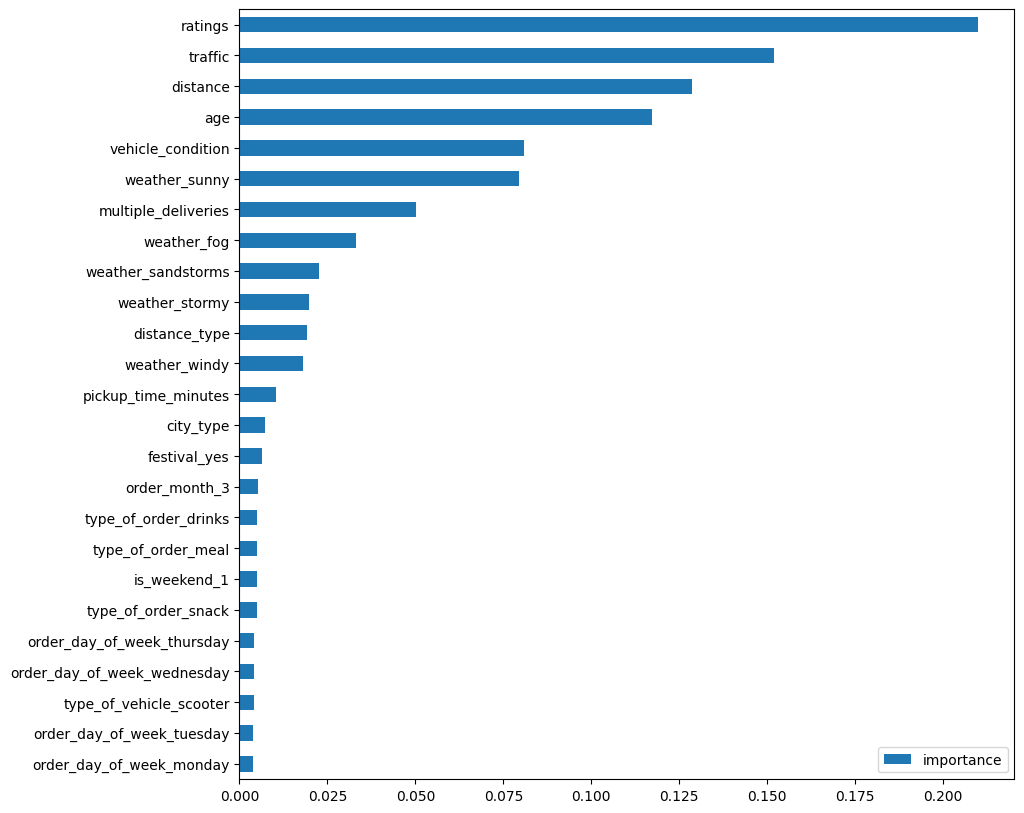

In [30]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=rfecv.transform(x_train_trans).columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

# Impute Missing values

In [31]:
temp_df =  cleaned_data.copy()
temp_df 

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,city_name,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,INDO,3,saturday,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,BANG,3,friday,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,BANG,3,saturday,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,COIMB,4,tuesday,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,CHEN,3,saturday,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,JAP,3,thursday,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,AGR,2,wednesday,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,CHEN,3,friday,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,COIMB,3,monday,0,5.0,afternoon,6.232393,medium


In [32]:
x=temp_df.drop(columns='time_taken')
y=temp_df['time_taken']
print(r'feature and target shape are {} and {}'.format(x.shape,y.shape))

# split the train and test data set
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

print(r'size of x train and y train are {} and {}'.format(x_train.shape,y_train.shape))

# check null values
print(f'total null values in train data set is {x_train.isnull().sum().sum()}')

feature and target shape are (45502, 18) and (45502,)
size of x train and y train are (36401, 18) and (36401,)
total null values in train data set is 14565


In [33]:
# missing values in train data

x_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
city_name                 0
order_month               0
order_day_of_week         0
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [34]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [35]:
# percentage of rows in data having missing values

(
    x_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)

17.0

# Imputation Pipeline

In [36]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [37]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'city_name',
 'order_month',
 'order_day_of_week',
 'is_weekend',
 'order_time_of_day']

In [38]:
# simple imputer to fill categorical vars with mode


simple_imputer = ColumnTransformer(
    transformers=[
        # Apply mode imputation (most frequent value) to specified features
        ("mode_imputer", SimpleImputer(strategy="most_frequent"), features_to_fill_mode),
        
        # Apply constant value imputation ("missing") to specified features
        ("missing_imputer", SimpleImputer(strategy="constant", fill_value="missing"), features_to_fill_missing)
    ],
    remainder="passthrough",              # Leave the remaining columns as-is (without transformation)
    n_jobs=-1,                            # Use all available CPU cores for parallel processing
    force_int_remainder_cols=False,       # Do not forcibly cast the remaining columns to integer type
    verbose_feature_names_out=False       # Disable verbose feature names in the output
)
simple_imputer

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['multiple_deliveries', 'festival',
                                  'city_type']),
                                ('missing_imputer',
                                 SimpleImputer(fill_value='missing',
                                               strategy='constant'),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'city_name', 'order_month',
                                  'order_day_of_week', 'is_weekend',
                                  'order_time_of_day'])],
                  verbose_feature_names_out=False)

In [39]:
simple_imputer.fit_transform(x_train)

,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,city_name,order_month,order_day_of_week,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
11029,1.0,no,metropolitian,windy,snack,electric_scooter,MUM,3,wednesday,0,evening,26.0,4.7,jam,2,10.0,9.177684,medium
15665,1.0,no,metropolitian,windy,drinks,motorcycle,SUR,3,thursday,0,afternoon,21.0,4.9,medium,2,5.0,6.081536,medium
14475,1.0,no,metropolitian,stormy,meal,scooter,MYS,3,saturday,1,missing,NaN,NaN,low,2,NaN,1.554563,short
29199,1.0,no,metropolitian,windy,buffet,motorcycle,JAP,4,monday,0,evening,32.0,4.7,medium,0,15.0,20.852271,very_long
22514,0.0,no,urban,sandstorms,meal,scooter,RANCHI,3,wednesday,0,night,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,no,metropolitian,sandstorms,meal,scooter,COIMB,4,monday,0,evening,29.0,4.7,jam,2,5.0,12.464367,long
44732,0.0,no,urban,cloudy,buffet,motorcycle,SUR,3,wednesday,0,morning,36.0,4.8,low,0,10.0,1.520432,short
38158,0.0,no,metropolitian,fog,buffet,scooter,BHP,2,thursday,0,evening,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,windy,meal,scooter,CHEN,3,saturday,1,afternoon,25.0,4.9,medium,2,5.0,7.760938,medium


In [40]:
simple_imputer.fit_transform(x_train).isna().sum()

multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
city_name                 0
order_month               0
order_day_of_week         0
is_weekend                0
order_time_of_day         0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [41]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type","city_name","order_month",
                    "order_day_of_week",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [42]:
# build a preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        # Apply Min-Max Scaling to numerical columns
        ("scale", MinMaxScaler(), num_cols),
        
        # Apply One-Hot Encoding to nominal categorical columns
        ("nominal_encode", 
         OneHotEncoder(
             drop="first",                   # Drop the first category to avoid multicollinearity
             handle_unknown="ignore",        # Ignore unknown categories during transformation
             sparse_output=False             # Return dense arrays instead of sparse matrices
         ), 
         nominal_cat_cols),
        
        # Apply Ordinal Encoding to ordinal categorical columns
        ("ordinal_encode", 
         OrdinalEncoder(
             categories=[traffic_order, distance_type_order],  # Define the order for ordinal categories
             encoded_missing_value=-999,                      # Encode missing values with -999
             handle_unknown="use_encoded_value",              # Handle unknown categories with a specific value
             unknown_value=-1                                 # Encode unknown categories as -1
         ), 
         ordinal_cat_cols)
    ],
    remainder="passthrough",                  # Leave remaining columns as-is (no transformations)
    n_jobs=-1,                                # Use all available CPU cores for parallel processing
    force_int_remainder_cols=False,           # Do not forcibly cast remainder columns to integers
    verbose_feature_names_out=False           # Disable verbose feature names in the transformed output
)



preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'city_name',
                                  'order_month', 'order_day_of_week',
                                  'is_weekend', 'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [43]:
preprocessor.fit_transform(x_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11029,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15665,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14475,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29199,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22514,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44732,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38158,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [44]:
# knn imputer

knn_imputer = KNNImputer(
    n_neighbors=5  # The number of nearest neighbors to use for imputing missing values
)

# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehi...
                                                   'city_name', 'order_month',
                                                   'order_day_of_week',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

In [45]:

processing_pipeline.fit_transform(x_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_missing,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,...,order_day_of_week_wednesday,is_weekend_1,order_time_of_day_evening,order_time_of_day_missing,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,multiple_deliveries,vehicle_condition
11029,0.315789,0.880,0.5,0.395429,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
15665,0.052632,0.960,0.0,0.236688,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
14475,0.536842,0.896,0.5,0.004588,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
29199,0.631579,0.880,1.0,0.993990,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
22514,0.736842,0.960,0.0,0.389195,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.880,0.0,0.563939,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,2.0
44732,0.842105,0.920,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38158,0.842105,0.760,0.5,0.189351,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,0.0,1.0
860,0.263158,0.960,0.0,0.322792,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0


In [46]:


model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor())])

In [ ]:

# fit the pipeline on data

model_pipe.fit(x_train,y_train_pt.values.ravel())

In [47]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehi...
                                                   'city_name', 'order_month',
                                                   'order_day_of_week',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

In [48]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor())])

In [49]:
# fit the pipeline on data

model_pipe.fit(x_train,y_train_pt.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor())])

In [52]:

# get the predictions
y_pred_train = model_pipe.predict(x_train)
y_pred_test = model_pipe.predict(x_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- city_type_nan
- festival_nan
- order_time_of_day_nan
- weather_nan
Feature names seen at fit time, yet now missing:
- order_time_of_day_missing
- weather_missing


In [50]:
# transform the data
x_train_trans=preprocessor.fit_transform(x_train)
x_test_trans=preprocessor.transform(x_test)

print(f'shape of x train is {x_train_trans.shape}')

# transform target column
print(f'shape of y_train is {y_train.shape}')

pt = PowerTransformer() # # Applies a power transformation to make data more Gaussian-like and stabilize variance

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
print(f'shape of y_train_pt is {y_train_pt.shape}')
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

shape of x train is (36401, 59)
shape of y_train is (36401,)
shape of y_train_pt is (36401, 1)
